Original idea: http://nemisig2019.nemisig.org/images/kimSlides.pdf


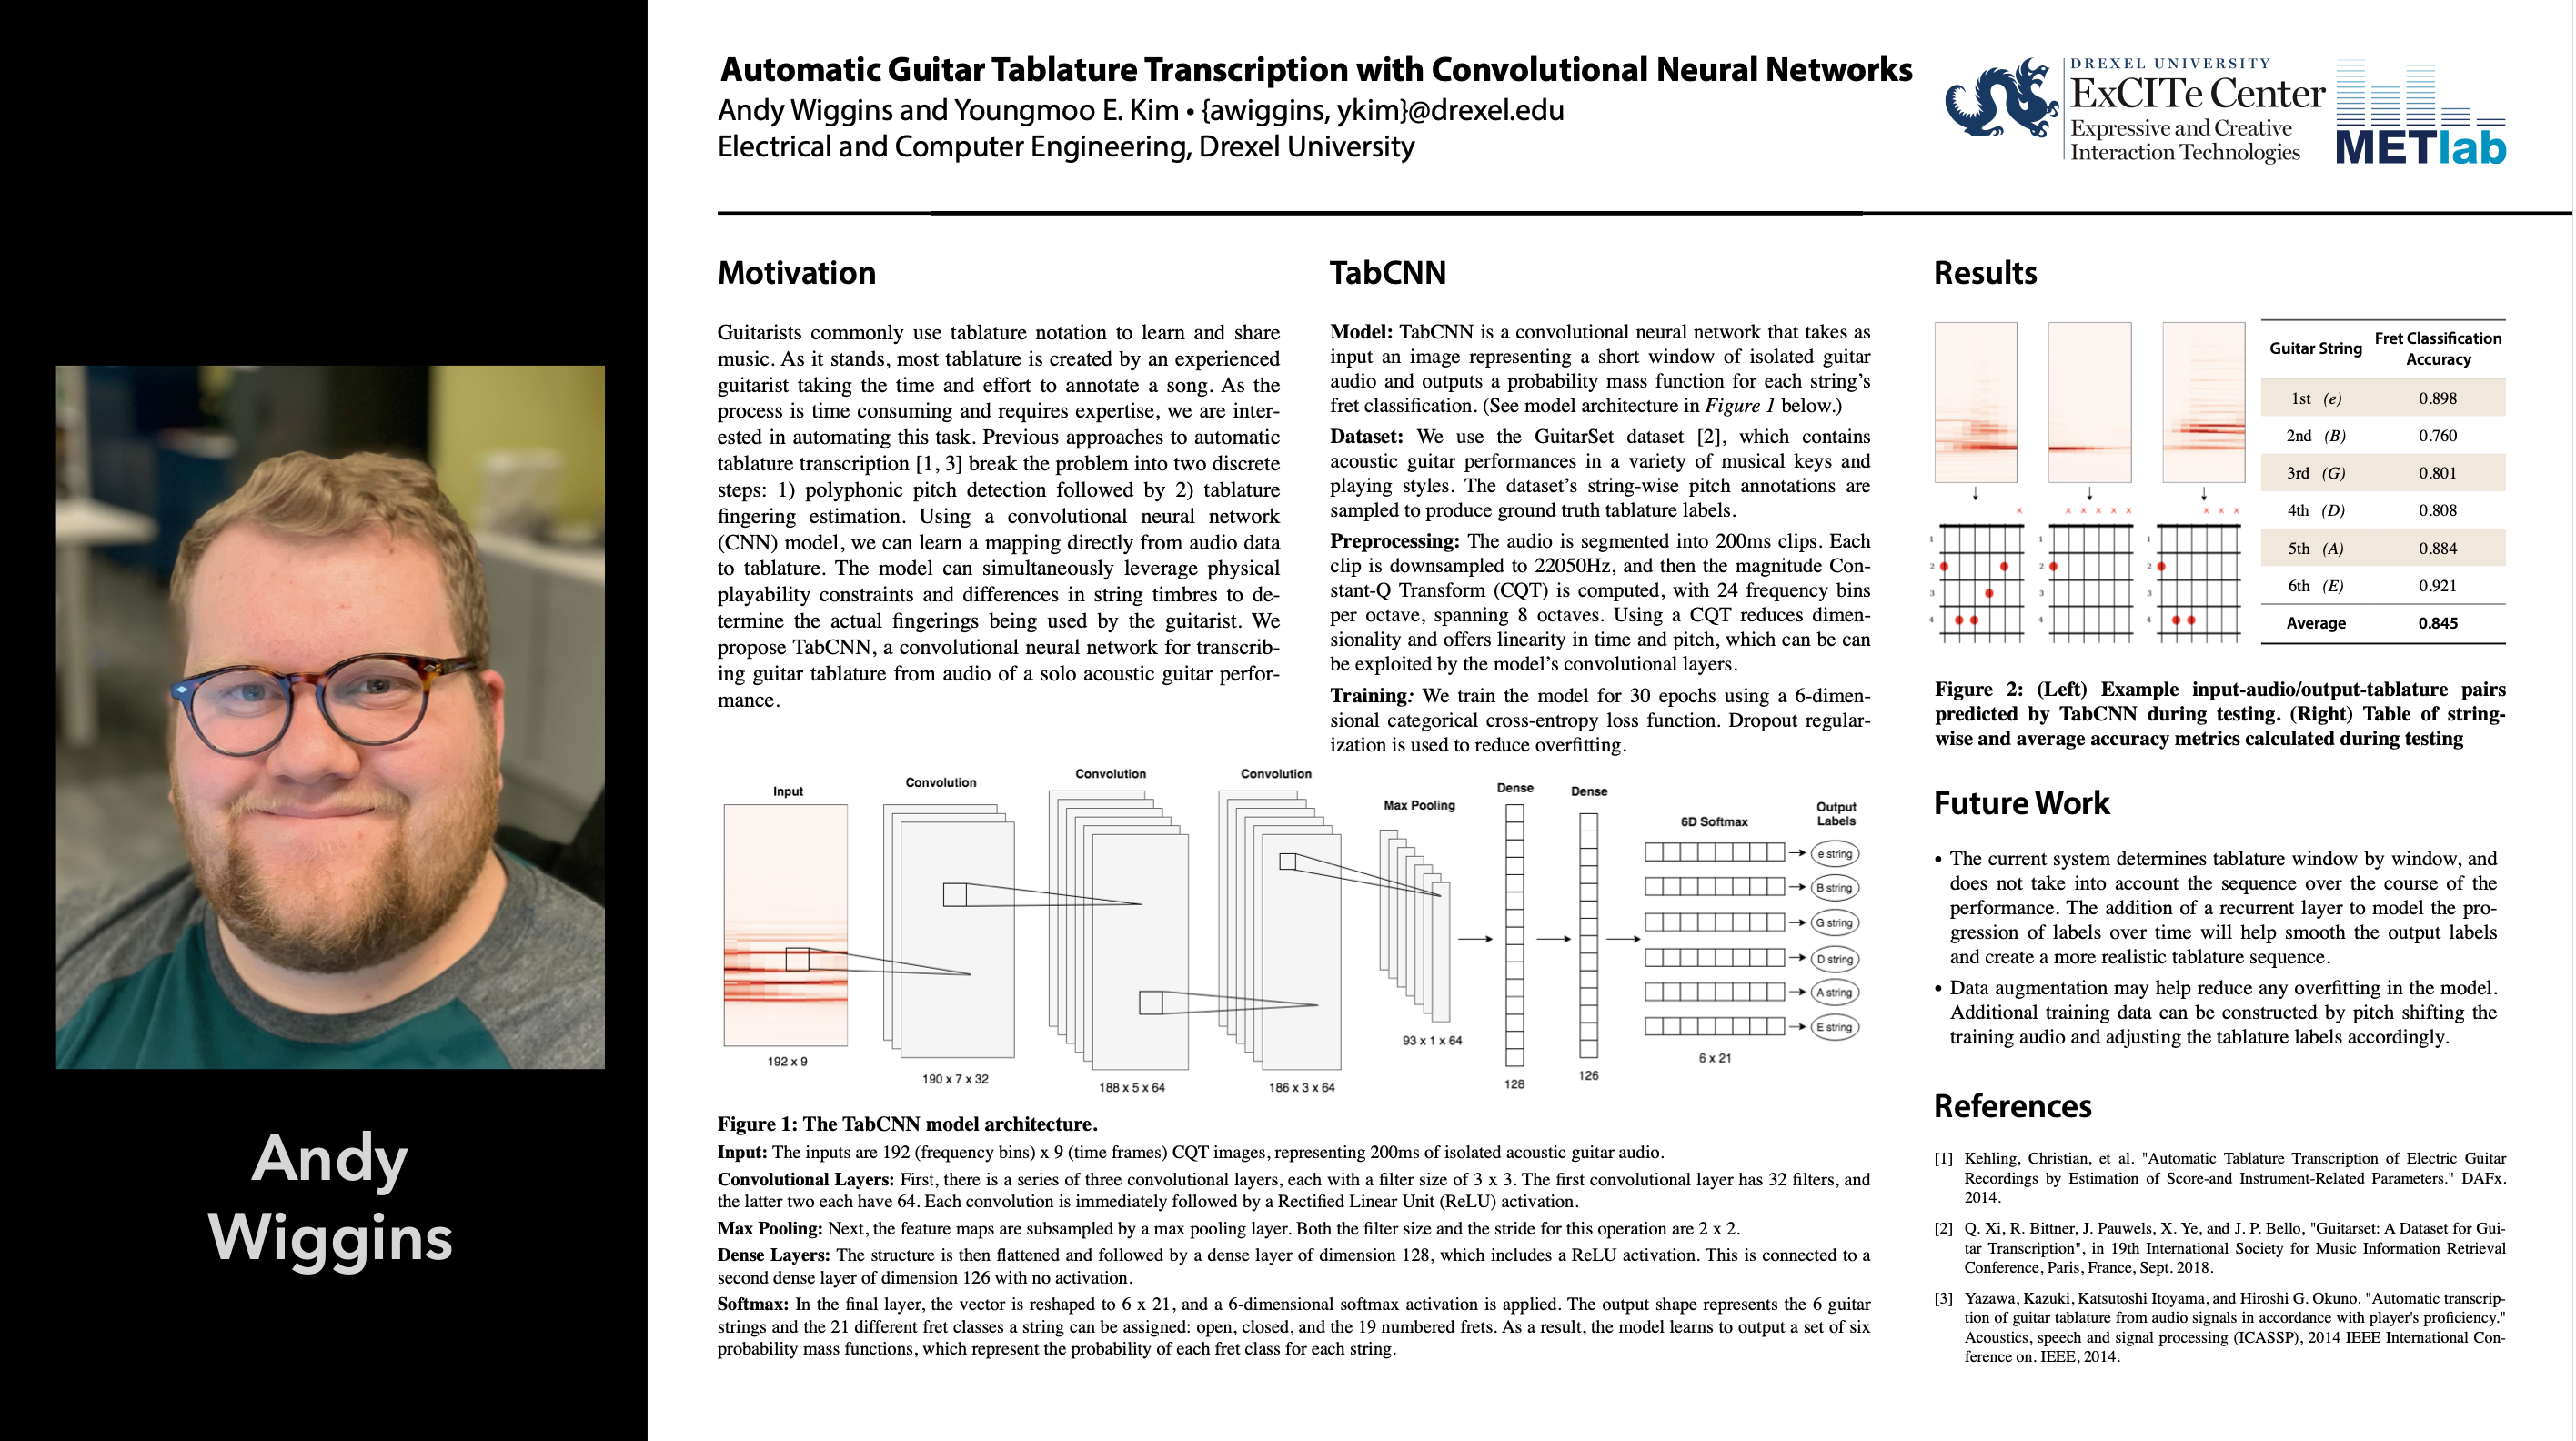

In [3]:
from IPython.display import Image

import librosa as _librosa
import librosa.display as _display
from presets import Preset

import numpy as np
import matplotlib.pyplot as plt

from os.path import isfile, join, isdir

import jams

print('Original idea: http://nemisig2019.nemisig.org/images/kimSlides.pdf')
Image(filename='data/poster.png') 


GuitarSet is a dataset for guitar transcription, available at https://github.com/marl/GuitarSet

Version 1.1.0, used in this project, contains 360 high-quality guitar recordings alongside rich annotations and metadata.


Andy Wiggins has a nice smile that keeps you motivated when wondering in the complex world of audio analysis :)

## Data Exploration

GuitarSet is a dataset that provides high-quality guitar recordings alongside rich annotations and metadata.

The dataset contains recordings of a variety of musical excerpts played on an acoustic guitar, along with time-aligned annotations of pitch contours, string and fret positions, chords, beats, downbeats, and playing style.

ParameterError: Audio buffer is not Fortran-contiguous. Use numpy.asfortranarray to ensure Fortran contiguity.

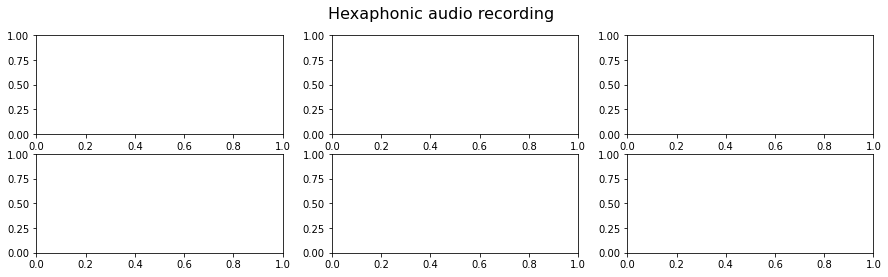

In [4]:
# Load preset parameters
librosa = Preset(_librosa)
librosa.display = _display

# Location of the hexaphonics pickups recordings
hexRecordingFolder = 'data/GuitarSet/audio/audio_hex-pickup_debleeded'
hexFormatExtension = '_hex_cln.wav'

# Location of the mono recordings
micRecordingFolder = 'data/GuitarSet/audio/audio_mic'
micFormatExtension = '_mic.wav'

# Display data from offset
offset = 0
# Duration of the audio data to be considered
duration= 0.2

def adjustPlot(fig, plt, ax):
    plt.ylim(-0.15, 0.15)
    plt.ylabel('Amplitude')
    ax.set_xlabel('Time (s)')
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)


testFile = '00_BN1-129-Eb_comp'

y, sr = librosa.load(join(hexRecordingFolder, testFile + hexFormatExtension), offset = offset, duration = duration, mono=False)

# Display hexaphonic audio recording for each guitar string
strings = [ 'e string', 'A string', 'D string', 'G string', 'B string', 'E string']
fig, axs = plt.subplots(2, 3, figsize=(15, 4))
fig.suptitle('Hexaphonic audio recording', fontsize=16)
for i in range(6):    
    ax = plt.subplot(2, 3, i+1)
    librosa.display.waveplot(y=y[i], sr=sr)   
    plt.title(strings[i])
    adjustPlot(fig, plt, ax)

# Display mono audio recording
y_mono, sr_mono = librosa.load(join(micRecordingFolder, testFile + micFormatExtension), offset = offset, duration = duration)
fig, axs = plt.subplots(1, 1, figsize=(15, 2))
plt.subplot(1,1,1)

librosa.display.waveplot(y=y_mono, sr=sr_mono)
fig.suptitle('Mono audio recording', fontsize=16)
adjustPlot(fig, plt, ax)






In the figure above we can see the waveform related to a fragment of audio file of 'duration' length, taken at position 'offset'. The hexaphonic recording contains the audio from each guitar string, which in a standard tuning ranges from the lower e string (6th) to the higher E string (1st)

NameError: name 'y_mono' is not defined

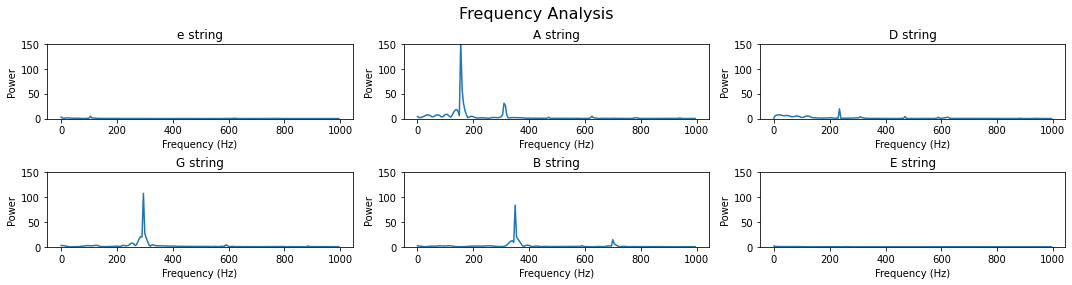

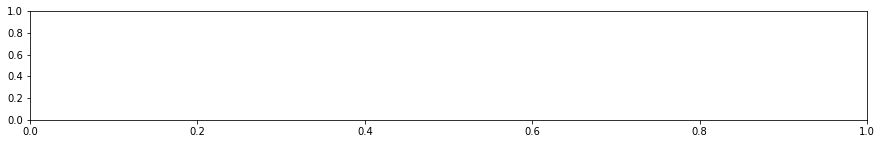

In [5]:
def adjustPlot(fig, plt, ax):
    plt.ylim(0, 150)
    plt.ylabel('Power')
    ax.set_xlabel('Frequency (Hz)')
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    
# Display the associated frequency spectrum
fig, axs = plt.subplots(2, 3, figsize=(15, 4))
fig.suptitle('Frequency Analysis', fontsize=16)
for i in range(6):    
    ax = plt.subplot(2, 3, i+1)
    
    # The FFT of the signal
    sig_fft = np.fft.fft(y[i])
    power = np.abs(sig_fft)
    # The corresponding frequencies
    sample_freq = np.abs(np.fft.fftfreq(y[i].size, d=1/sr))
    plt.plot(sample_freq[0:200], power[0:200])
    plt.title(strings[i])
    adjustPlot(fig, plt, ax)
    
fig, axs = plt.subplots(1, 1, figsize=(15, 2))
ax = plt.subplot(1,1,1)

# The FFT of the signal
sig_fft = np.fft.fft(y_mono)
power = np.abs(sig_fft)
# The corresponding frequencies
sample_freq = np.abs(np.fft.fftfreq(y_mono.size, d=1/sr_mono))
plt.plot(sample_freq[0:200], power[0:200])
plt.title('Mono recording')
adjustPlot(fig, plt, ax)    


In the figure above we can see the frequency of the audio recording. The top 6 graphs contain the frequency spectrum of the 6 chords, while the 'Mono recording' graph contain the frequency spectrum of the mono signal.
We can see that the mono signal correspond to the sum of the individual strings.


In [6]:
# Calculating the frequency related to the strongest signal
for i in range(6):
    sig_fft = np.fft.fft(y[i])
    power = np.abs(sig_fft)        
    # Normalised
    norm = np.linalg.norm(power)    
    power = power / norm    
    # The corresponding frequencies
    sample_freq = np.abs(np.fft.fftfreq(y[i].size, d=1/sr))
    freq = sample_freq[power.argmax()]
    if freq != 0:
        print(strings[i], '- detected frequency ', freq, librosa.hz_to_note(freq))


e string - detected frequency  105.0 G#2
A string - detected frequency  155.0 D#3
D string - detected frequency  235.0 A#3
G string - detected frequency  295.0 D4
B string - detected frequency  350.0 F4


The code above scans the frequency spectrum to detect the frequency associated with the maximum power. Each audio is related to a single string, so the result is quite accurate. In this case we print out the detected frequency for each string, even if the power of the signal is very low.

In [7]:
annotationFolder = 'data/GuitarSet/annotation'
annotationExtension = '.jams'

with open(join(annotationFolder, testFile + annotationExtension)) as jams_file:
    data = jams.load(jams_file)
    for a in data['annotations']:  
        if a['namespace'] == 'pitch_contour':
            obs = a['data']
            currentSource = a['annotation_metadata']['data_source']
            for o in obs:
                if o.time >= offset and o.time <= offset+duration:
                    print(strings[int(currentSource)], ' - annotated frequency', 
                          o.value['frequency'], librosa.hz_to_note(o.value['frequency']))
                    break
                if o.time > offset:
                    break            
    

A string  - annotated frequency 155.989 D#3
G string  - annotated frequency 295.282 D4
B string  - annotated frequency 349.936 F4


The annotated observations are very close to the value detected from the FFT. The value for the detected notes and annotations are the same! 